<a href="https://colab.research.google.com/github/geande/covid-19-predictor/blob/main/MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import jax.numpy as np
from jax import random, vmap, grad, jit
from jax.flatten_util import ravel_pytree
from jax.experimental import optimizers

import itertools
from functools import partial
from tqdm import trange
import numpy.random as npr
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
from scipy.integrate import solve_ivp
import pandas

# **Multi-Layer Perceptron Implementation**


We use glorot initialization and the adam optimizer for SGD.  This code was developed for HW assignments in ENM360 with Paris Perdikaris and Georgios Kissas.

In [33]:
class MLP():
  def __init__(self, X, y, layers, init_method = 'glorot', rng_key = random.PRNGKey(0)):
    # Normalize data
    self.Xmean, self.Xstd = X.mean(0), X.std(0)
    self.Ymean, self.Ystd = y.mean(0), y.std(0)
    X = (X - self.Xmean)/self.Xstd
    y = (y - self.Ymean)/self.Ystd

    # Store the normalized trained data
    self.X = X
    self.y = y
    self.layers = layers

    # Use stax to set up network initialization and evaluation functions
    self.net_init, self.net_apply = self.init_MLP(init_method)
    
    # Initialize parameters, not committing to a batch shape
    self.net_params = self.net_init(rng_key, layers)
                
    # Use optimizers to set optimizer initialization and update functions
    self.opt_init, \
    self.opt_update, \
    self.get_params = optimizers.adam(optimizers.exponential_decay(1e-3, 
                                                                    decay_steps=100, 
                                                                    decay_rate=0.99))
    self.opt_state = self.opt_init(self.net_params)

    # Logger to monitor the loss function
    self.loss_log = []
    self.itercount = itertools.count()

    # Logger to monitor error function

    self.error_log = []

  """
  First, we must initialize our MLP model.  We use a glorot initialization for 
  a uniform or a normal distribution for the weights. The init_W function 
  initializes our parameters (weights) according to each of the type of
  intialization.  We then use the distribution of weights to initialize the
  weights and biases for each layer of the MLP.
  """

  def init_MLP(self, method = 'glorot'):
    # Define init function
    def _init(rng_key, layers):
        # Define methods for initializing the weights
        if method == 'glorot':
          def init_W(rng_key, size):
            in_dim = size[0]
            out_dim = size[1]
            glorot_stddev = 1. / np.sqrt((in_dim + out_dim) / 2.)
            return glorot_stddev*random.normal(rng_key, (in_dim, out_dim))
        elif method == 'random':
          def init_W(rng_key, size):
            in_dim = size[0]
            out_dim = size[1]
            return random.uniform(rng_key, (in_dim, out_dim))
        # Perform initialization
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            rng_key, _ = random.split(rng_key)
            W = init_W(rng_key, size=[layers[l], layers[l+1]])
            b = np.zeros((1,layers[l+1]))
            weights.append(W)
            biases.append(b)  
        params = weights, biases
        return params
    
    """
    Next, we define the apply function, which creates the output through 
    the layers of the MLP, given a particular input.  The matrix H applies the
    hyperbolic tangent activation function to the (H dot W) + b.  Once we get
    through all layers, we can then take the last entry in the weights and
    biases matrices and perform the same activation to output what the last
    layer will yield.
    """

    # Define apply function
    def _apply(params, input):
        H = input
        weights, biases = params
        num_layers = len(self.layers)
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = np.tanh(np.add(np.dot(H, W), b))
        W = weights[-1]
        b = biases[-1]
        H = np.add(np.dot(H, W), b)
        return H.flatten()
    return _init, _apply

  """
  Here, we use the standard formula for squared error to calculate the loss
  for each element in a batch.  We take as inputs the current parameters and 
  batch of data, and output the loss of a single value.
  """

  def per_example_loglikelihood(self, params, batch):
    X, y = batch
    y_pred = self.net_apply(params, X)
    loss = (y - y_pred)**2
    return loss

  """
  Now, we can leverage the per-batch loss calculation to determine the loss of 
  the entire batch as it passes through the MLP.  We take as inputs the current
  parameters and batch of data, and output the loss of the entire batch.
  """ 

  def loss(self, params, batch):
    # Implementation #1
    pe_loss = lambda x: self.per_example_loglikelihood(params, x)
    loss = np.sum(vmap(pe_loss)(batch))
    return loss

  """
  We can now update parameters based on the Adam Optimizer's update rule.  This
  means that we are updating parameters with a variable learning rate.  We use
  the partial decorator to indicate we'd like this function to utilize a
  hardware accelerator to compile the code faster.  We take as inputs the 
  iteration number, the current optimized state of the network, and the current
  batch number.
  """

  # Define a compiled update step
  @partial(jit, static_argnums=(0,))
  def step(self, i, opt_state, batch):
      params = self.get_params(opt_state)
      g = grad(self.loss)(params, batch)
      return self.opt_update(i, g, opt_state)

  """
  This function is used to create each batch from a given data set and output it
  in a stream.  We take as inputs the dimension of the training data, the number
  of batches, and the desired batch size.  We output the training data as the 
  desired number of batches whose dimensions match the desired size.
  """

  def data_stream(self, n, num_batches, batch_size):
    rng = npr.RandomState(0)
    while True:
      perm = rng.permutation(n)
      for i in range(num_batches):
        batch_idx = perm[i*batch_size:(i+1)*batch_size]
        yield self.X[batch_idx], self.y[batch_idx] # Changed from self.X[batch_idx, :] due to dimensionality issues

  """
  This is how we train the model.  Using the data_stream function to create
  batches, we can iterate through each epoch to determine how the parameters 
  should be updated using our step function.  We take as inputs the number of 
  epochs and the desired batch size.  We output nothing, but after this function
  has run, we have generated the optimized state for our MLP.
  """

  def train(self, num_epochs = 100, batch_size = 64):   
    n = self.X.shape[0]
    num_complete_batches, leftover = divmod(n, batch_size)
    num_batches = num_complete_batches + bool(leftover) 
    batches = self.data_stream(n, num_batches, batch_size)
    pbar = trange(num_epochs)
    for epoch in pbar:
      for _ in range(num_batches):
        batch = next(batches)
        self.opt_state = self.step(next(self.itercount), self.opt_state, batch)
      self.net_params = self.get_params(self.opt_state)
      loss_value = self.loss(self.net_params, batch)
      self.loss_log.append(loss_value)
      # error_value = self.error(self.net_params, batch)
      # self.error_log.append(error_value)
      pbar.set_postfix({'Loss': loss_value})

  """
  This function is used to generate the prediction our model produces given a 
  particular test data set.  We take as inputs the current parameters of our 
  model and the test data, and we output the prediction our model produces using
  the inputs.
  """

  def predict(self, params, X_star):
    X_star = (X_star - self.Xmean)/self.Xstd
    pred_fn = lambda x: self.net_apply(params, x)
    y_pred = vmap(pred_fn)(X_star)
    y_pred = y_pred*self.Ystd + self.Ymean
    return y_pred

  """
  This function is used to compute the activation of each layer in the the MLP
  using the hyperbolic tangent.  This is very similar to how we initialize the 
  network.  We take as inputs the current parameters and a test data set, and we
  output the matrix of each layer's output using the test data.
  """

  def compute_activations(self, params, X_star):
    X_star = (X_star - self.Xmean)/self.Xstd
    def MLP_pass(params, input):
      H = input
      H_list = []
      H_list.append(H)
      weights, biases = params
      num_layers = len(self.layers)
      for l in range(0,num_layers-2):
          W = weights[l]
          b = biases[l]
          H = np.tanh(np.add(np.dot(H, W), b))
          H_list.append(H)
      W = weights[-1]
      b = biases[-1]
      H = np.add(np.dot(H, W), b)
      H_list.append(H)
      return H_list
    # Get predictions
    pred_fn = lambda x: MLP_pass(params, x)
    H_list = vmap(pred_fn)(X_star)
    return H_list

We can perform this learning on NJ as a case study.

In [34]:
txt = pandas.read_csv(r'https://covidtracking.com/data/download/new-jersey-history.csv', parse_dates=["date"])

SIRD ODE system

In [35]:
# Define our system of ODEs for the time series data.
def systemODE(x, t, params):
  S, I, R, D, C = x # states
  beta, gamma, mu, N = params # parameters
  derivatives = [-beta*S*I/N,    # dS/dt - this represents the rate of change of susceptible individuals
                 (beta*S/N - (gamma + mu))*I,   # dI/dt - this represents the rate of change of current infections (for certain datasets, we may only have the number of infected individuals)
                 gamma*I,   # dR/dt - this represents the rate of change of total infection recoveries
                 mu*I,    # dD/dt - this represents the rate of change of total deaths due to infection
                 beta*S*I/N   # dC/dt - this represents the rate of change of total cumulative caseload
                ]
  return np.array(derivatives)

In [36]:
# Now, we need to define the initial values for our system. These will be the conditions when all was well with the world 

N = 9032872

I_init = 2 # Initial infected (found by calculating 33/state_population)
R_init = 0.0
D_init = 0.0
C_init = I_init + R_init + D_init
S_init = N - C_init

F0 = np.array([S_init, I_init, R_init, D_init, C_init])

# We will also define some parameters that have been provided to us as part of the paper
beta = 1/5.2
gamma = 1/18
mu = 0.01

params = np.array([beta, gamma, mu, N])

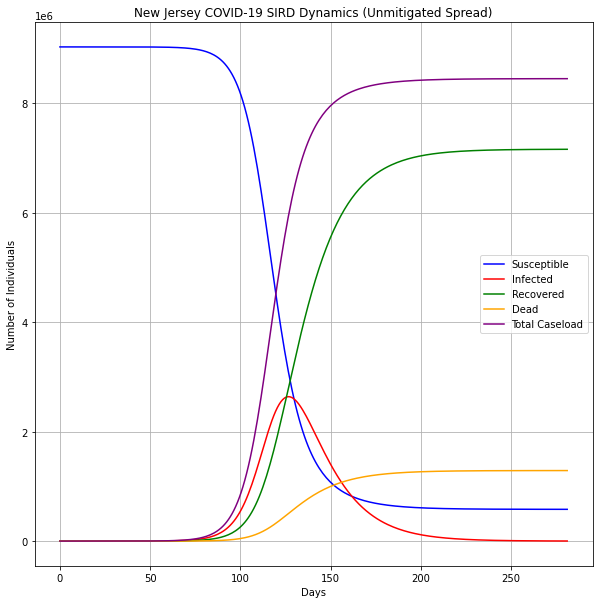

In [37]:
# Now that we have defined everything that we need to analyze the system of ODEs, we can solve and plot our solutions.
from scipy.integrate import odeint

t = np.linspace(0, 281, 281)
sol = odeint(systemODE, F0, t, args=(params,))

# Plotting
fig1 = plt.figure(figsize = (10, 10), facecolor='w')
plt.plot(t, sol[:, 0], 'b', label = 'Susceptible')
plt.plot(t, sol[:, 1], 'r', label = 'Infected')
plt.plot(t, sol[:, 2], 'g', label = 'Recovered')
plt.plot(t, sol[:, 3], 'orange', label = 'Dead')
plt.plot(t, sol[:, 4], 'purple', label = 'Total Caseload')
plt.legend(loc = 'best')
plt.xlabel('Days')
plt.ylabel('Number of Individuals')
plt.title('New Jersey COVID-19 SIRD Dynamics (Unmitigated Spread)')
plt.grid()

Lets do a small scale data collection

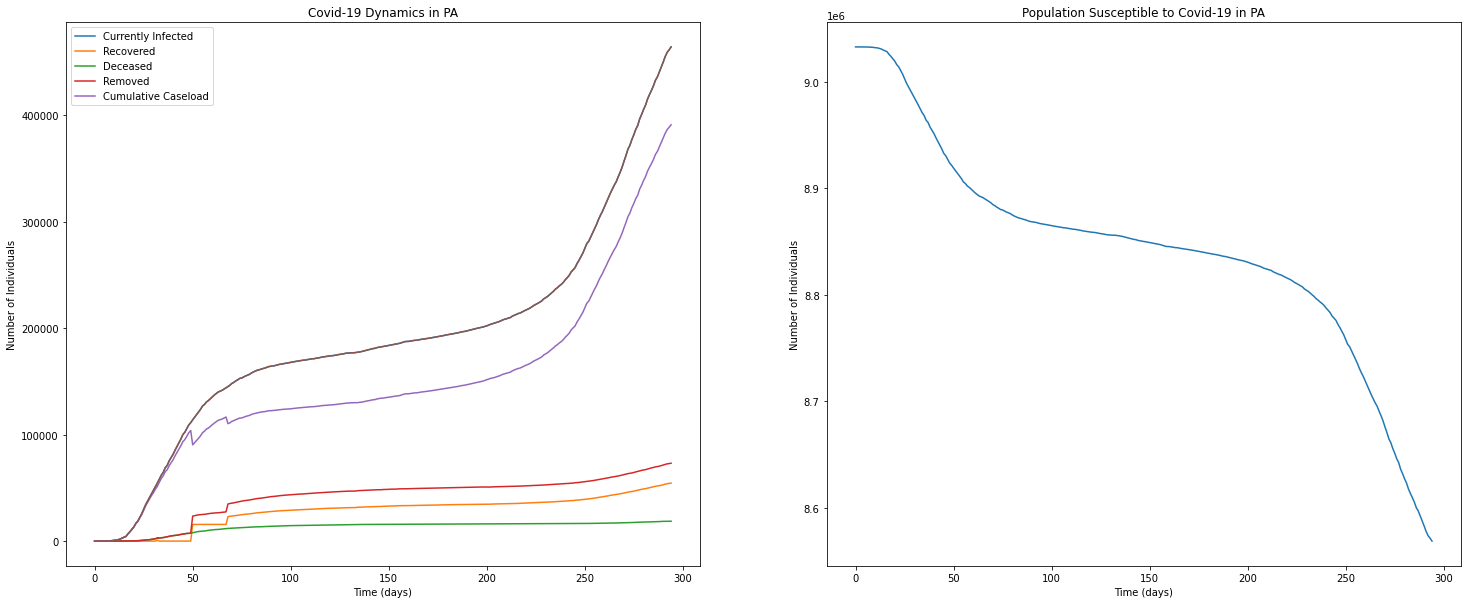

In [38]:
points = 295
N = 9032872

# here im iterating through the csv and collecting the data for each of the fields that were interested in tracking
positive = []
positiveInc = []
death = []
deathIncrease = []
recovered = []

counter = 0;

for i in range(0, points):

  I = 0
  I_inc = 0
  D = 0
  R = 0

  if (txt["positive"][i] >= 0):
    I = txt["positive"][i]
  if (txt["positiveIncrease"][i] >= 0):
    I_inc = txt["positiveIncrease"][i]
  if (txt["death"][i] >= 0):
    D = txt["death"][i]
  if (txt["recovered"][i] >= 0):
    R = txt["recovered"][i]

  positive.append(I)
  positiveInc.append(I_inc)
  death.append(D)
  recovered.append(R)

  #print(txt["positive"][i])

positive.reverse()
positiveInc.reverse()
death.reverse()
recovered.reverse()


Infected_data = np.array(positive) # state tracking the total infected individuals
Deceased_data = np.array(death) # state tracking the total deceased individuals
Recovered_data = np.array(recovered) # state tracking the total recovered individuals
Removed_data = np.add(Recovered_data, Deceased_data) # state tracking the total number of removed individuals
CurrentlyInfected_data = np.subtract(Infected_data, Removed_data)
CumulativeCaseload_data = Infected_data # state tracking the cumulative caseload fraction
Susceptible_data = N - CumulativeCaseload_data # state tracking the susceptible fraction

plt.figure(figsize=(25,10), facecolor="w")
plt.subplot(1,2,1)
plt.plot(Infected_data)
plt.plot(Recovered_data)
plt.plot(Deceased_data)
plt.plot(Removed_data)
plt.plot(CurrentlyInfected_data)
plt.plot(CumulativeCaseload_data)
plt.title("Covid-19 Dynamics in PA")
plt.xlabel("Time (days)")
plt.ylabel("Number of Individuals")
plt.legend(("Currently Infected", "Recovered", "Deceased", "Removed", "Cumulative Caseload"))
plt.subplot(1,2,2)
plt.plot(Susceptible_data)
plt.title("Population Susceptible to Covid-19 in PA")
plt.xlabel("Time (days)")
plt.ylabel("Number of Individuals")

data_Collected = np.vstack((Susceptible_data, CurrentlyInfected_data, Recovered_data, Deceased_data, CumulativeCaseload_data))

# **Data Driven Parameterization**


100%|██████████| 200/200 [00:09<00:00, 20.34it/s, Loss=4.1696544]


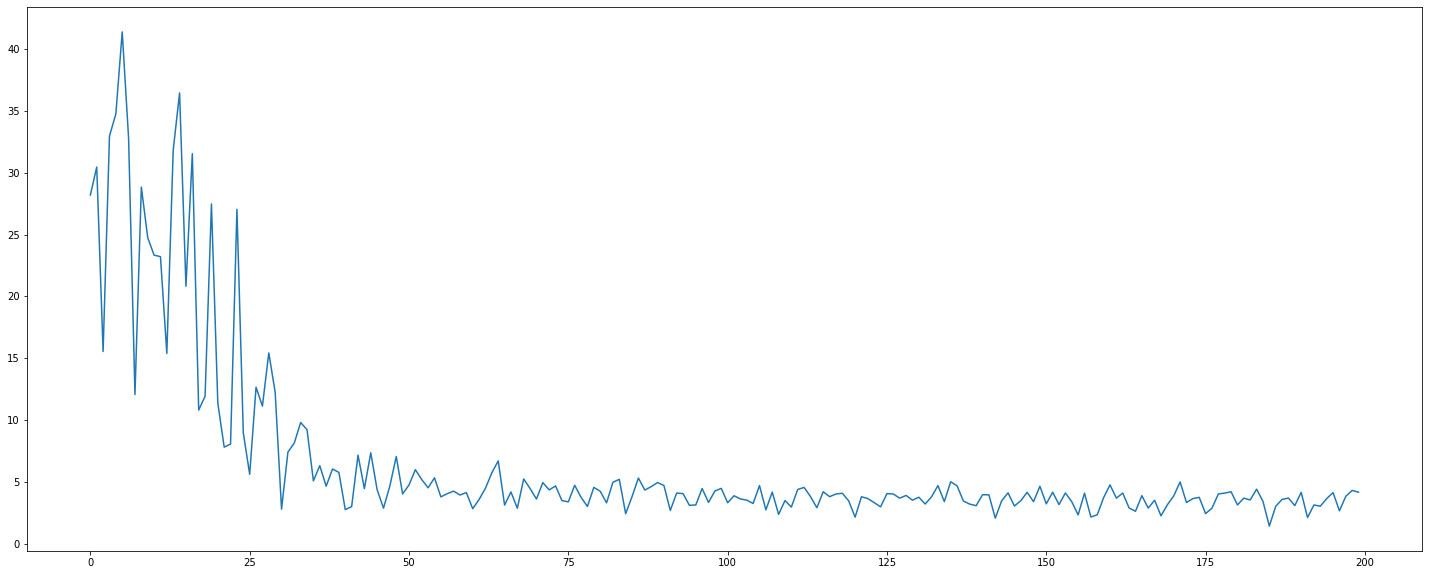

In [39]:
# for beta

# Determine the change in actual cases, which will define the training data
change_cases = np.gradient(CumulativeCaseload_data) # Training data

# Additionally, pull the time series data from our system of ODEs. We will in particular want to check out the value of dC/dt
t = np.linspace(0, points, points) # Define time range
caseload_data_ODE = np.gradient(sol[:, 4]) # Input data

# We want caseload_data and change_cases to match as closely as possible. To do this, we will train an MLP which will compare these two and modify ONLY beta

start = 70

dataset = data_Collected.T # Call datast

# Determine value of 4/5 of data
train_size = int(len(dataset[start:]) * (4.0/5.0))

# Create the X array, which will contain a column of the Infected data and a column of the Susceptible data
Xtotal = np.array([CurrentlyInfected_data, Susceptible_data]).T
X = Xtotal[start:start + train_size,:]

# Create the y array, which will be the dC/dt data for the actual dataset
y = change_cases[start:start + train_size]

# Create y_pred, which will be the dC/dt data for that the ODE proposes
y_pred = caseload_data_ODE[start:start + train_size]

# Create X_star and y_star
X_star = Xtotal[start+train_size:,:]
y_star = change_cases[start+train_size:]

layers = [2, 32, 32, 32, 1] # Defining our model and the layers of the neural network
init_method = 'glorot'
rng_key = random.PRNGKey(0)
model = MLP(X, y, layers, init_method, rng_key)

model.train(num_epochs = 200, batch_size = 64)
opt_params = model.net_params
beta_pred = model.predict(opt_params, Xtotal[start:,:])
plt.figure(figsize=(25,10), facecolor='w')
plt.plot(model.loss_log)

In [40]:
# Determining beta based off y_pred and known values from actual data
I = CurrentlyInfected_data[start:]
S = Susceptible_data[start:]

size_beta = len(beta_pred)
beta_array = []
val_total = 0

# Create an array of the beta values, which is ultimately what we want to vary in our data
for i in range(size_beta):
  val = (beta_pred[i] * N) / (S[i] * I[i])
  beta_array.append(val)


100%|██████████| 200/200 [00:09<00:00, 21.09it/s, Loss=10.362906]


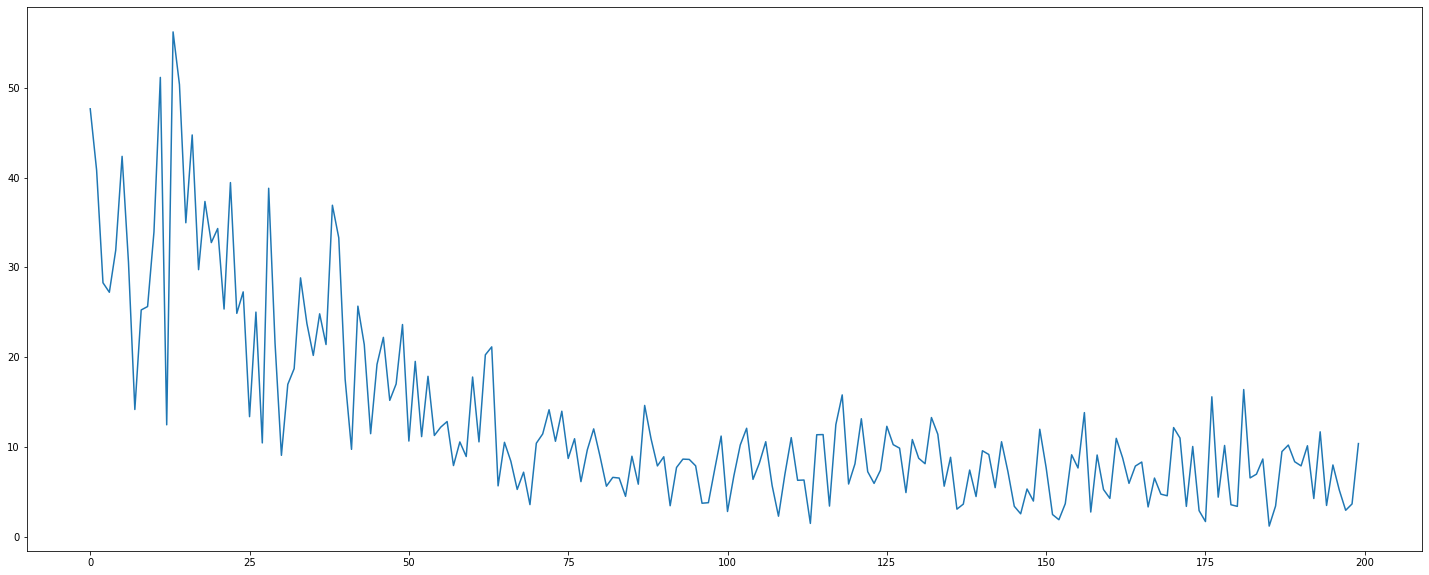

In [41]:
# for mu

change_deaths = np.gradient(Deceased_data[start:])

mu_data = np.divide(change_deaths, CurrentlyInfected_data[start:])

dataset = data_Collected.T # Call datast

# Determine value of 2/3 of data
train_size = int(len(dataset[start:]) * (4.0/5.0))

# Create the X array, which will contain a column of the Infected data and a column of the Susceptible data
X = CurrentlyInfected_data[start:start+train_size]

# Create the y array, which will be the dC/dt data for the actual dataset
y = mu_data[0:train_size]

# Create X_star and y_star
X_star = CurrentlyInfected_data[start+train_size:]
y_star = mu_data[start+train_size:]

layers = [1, 32, 32, 32, 1] # Defining our model and the layers of the neural network
init_method = 'glorot'
model = MLP(X, y, layers, init_method, rng_key)

model.train(num_epochs = 200, batch_size = 64)
opt_params = model.net_params
mu_pred = model.predict(opt_params, CurrentlyInfected_data[start:])

plt.figure(figsize=(25,10), facecolor='w')
plt.plot(model.loss_log)


100%|██████████| 200/200 [00:09<00:00, 21.28it/s, Loss=9.046474]


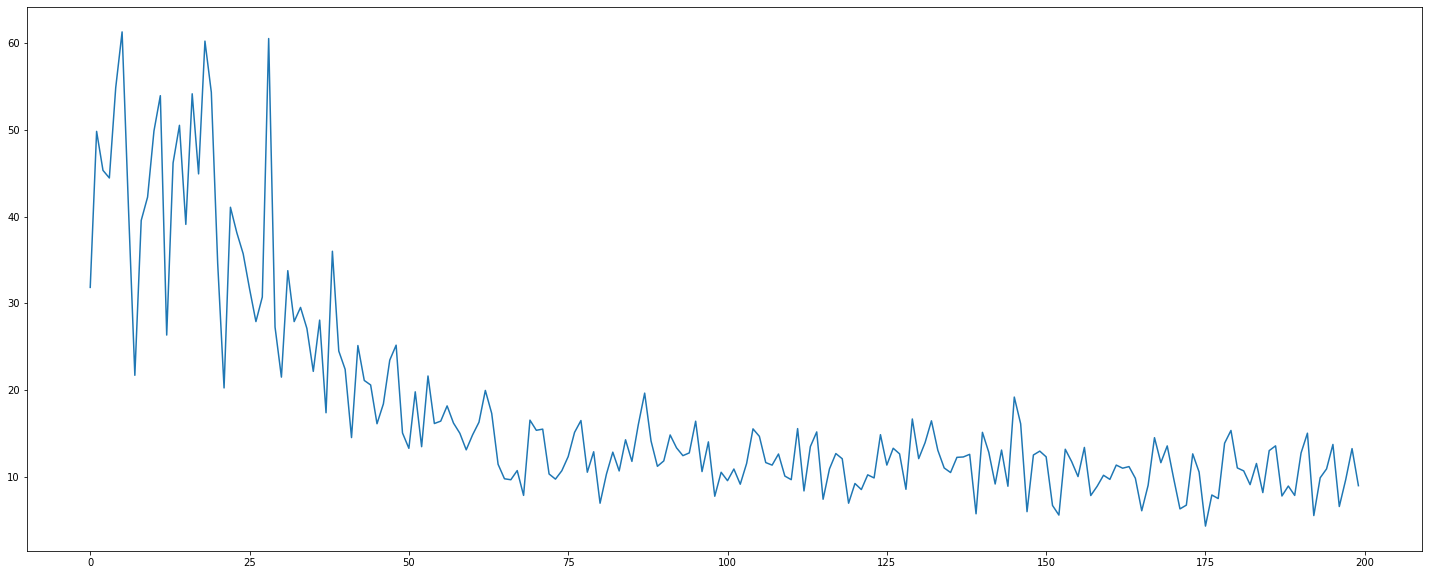

In [42]:
# for gamma

change_recov = np.gradient(Recovered_data[start:])

gamma_data = np.divide(change_recov, CurrentlyInfected_data[start:])

dataset = data_Collected.T # Call datast

# Determine value of 2/3 of data
train_size = int(len(dataset[start:]) * (4.0/5.0))

# Create the X array, which will contain a column of the Infected data and a column of the Susceptible data
X = CurrentlyInfected_data[start:start+train_size]

# Create the y array, which will be the dC/dt data for the actual dataset
y = gamma_data[0:train_size]

# Create X_star and y_star
X_star = CurrentlyInfected_data[start+train_size:]
y_star = gamma_data[start+train_size:]

layers = [1, 32, 32, 32, 1] # Defining our model and the layers of the neural network
init_method = 'glorot'
model = MLP(X, y, layers, init_method, rng_key)

model.train(num_epochs = 200, batch_size = 64)
opt_params = model.net_params
gamma_pred = model.predict(opt_params, CurrentlyInfected_data[start:])

plt.figure(figsize=(25,10), facecolor='w')
plt.plot(model.loss_log)

Now we can functionalize our parameters and redefine our ODE system

In [55]:
def be(t):
  ind = int(t) - start
  if (ind < 225):
    bet = float(beta_array[ind])
    return bet
  elif (ind >= 225):
    bet = float(beta_array[-1])
    return bet

In [56]:
def ga(t):
  ind = int(t) - start
  if (ind < 225):
    gam = float(gamma_pred[ind])
    return gam
  elif (ind >= 225):
    gam = float(gamma_pred[-1])
    return gam

In [57]:
def m(t):
  ind = int(t) - start
  if (ind < 225):
    muy = float(mu_pred[ind])
    return muy
  elif (ind >= 225):
    muy = float(mu_pred[-1])
    return muy

In [58]:
# Define our system of ODEs for the time series data.
def systemODE(t, x, params):
  S, I, R, D, C = x # states
  beta, gamma, mu, N = params # parameters
  derivatives = [-1.0*be(t)*S*I/N,    # dS/dt - this represents the rate of change of susceptible individuals
                 (be(t)*S/N - (ga(t) + m(t)))*I,   # dI/dt - this represents the rate of change of current infections (for certain datasets, we may only have the number of infected individuals)
                 ga(t)*I,   # dR/dt - this represents the rate of change of total infection recoveries
                 m(t)*I,    # dD/dt - this represents the rate of change of total deaths due to infection
                 be(t)*S*I/N   # dC/dt - this represents the rate of change of total cumulative caseload
                ]
  return np.array(derivatives)

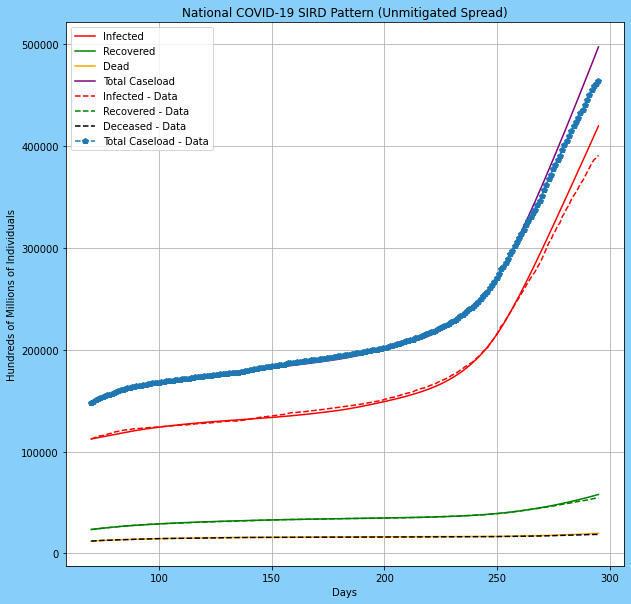

In [62]:
# Now, we need to define the initial values for our system. These will be the conditions when all was well with the world 

train_size = 70

N = 9032872

I_init = CurrentlyInfected_data[train_size] # Initial infected (found by calculating 33/state_population)
R_init = Recovered_data[train_size]
D_init = Deceased_data[train_size]
C_init = CumulativeCaseload_data[train_size]
S_init = Susceptible_data[train_size]

F0 = np.array([S_init, I_init, R_init, D_init, C_init])

# We will also define some parameters that have been provided to us as part of the paper
beta = 0.105
gamma = 1/18
mu = 0.01

params = np.array([beta, gamma, mu, N])# Now that we have defined everything that we need to analyze the system of ODEs, we can solve and plot our solutions.
from scipy.integrate import odeint

t = np.linspace(train_size, 295, 295 - train_size)

sol = solve_ivp(systemODE, (train_size, 295), F0, method='RK45', t_eval=t, args=(params,))

# Plotting
fig1 = plt.figure(figsize = (10, 10))
plt.plot(sol.t, sol.y[1], 'r', label = 'Infected')
plt.plot(sol.t, sol.y[2], 'g', label = 'Recovered')
plt.plot(sol.t, sol.y[3], 'orange', label = 'Dead')
plt.plot(sol.t, sol.y[4], 'purple', label = 'Total Caseload')
plt.plot(t, CurrentlyInfected_data[train_size:], 'r--', label = 'Infected - Data')
plt.plot(t, Recovered_data[train_size:], 'g--', label = 'Recovered - Data')
plt.plot(t, Deceased_data[train_size:], 'k--', label = 'Deceased - Data')
plt.plot(t, CumulativeCaseload_data[train_size:], 'p--', label = 'Total Caseload - Data')
plt.legend(loc = 'best')
plt.xlabel('Days')
plt.ylabel('Hundreds of Millions of Individuals')
plt.title('National COVID-19 SIRD Pattern (Unmitigated Spread)')
fig1.patch.set_facecolor('lightskyblue')
plt.grid()


S_exact = []
I_exact = []
R_exact = []
D_exact = []
C_exact = []

for i in range(0, sol.y.shape[1]):
  S_exact.append(sol.y[0][i])
  I_exact.append(sol.y[1][i])
  R_exact.append(sol.y[2][i])
  D_exact.append(sol.y[3][i])
  C_exact.append(sol.y[4][i])

Se = np.asarray(S_exact, dtype=np.float32)
Ie = np.asarray(I_exact, dtype=np.float32)
Re = np.asarray(R_exact, dtype=np.float32)
De = np.asarray(D_exact, dtype=np.float32)
Ce = np.asarray(C_exact, dtype=np.float32)

data_Analytical = np.vstack((Se, Ie, Re, De, Ce))